### Dinkey Creek Projected Climate
Climate metadata
Download date
Download link
Spatial subset

Processing workflow
Rough description of each simulation (with links)

Notes about fire weather production

#### Required libraries

In [1]:
# Load required libraries and establish data directories

# ------- Notebook config
%matplotlib inline
import matplotlib.colors
import matplotlib.pyplot as plt

# ------- Load dependencies
import pandas as pd
import numpy as np
import random
import seaborn as sns
import gdal, os, osr

# Curve fitting and linear models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import patsy # R-esque version of formula declaration

# ------- Working directory
dataDir = 'Z:/Dan K/DinkeyCreek/Climate Projections/CMIP5_Components/'
DFFSDir = 'Z:/Dan K/DinkeyCreek/Fire Weather/'

C:\Anaconda\lib\site-packages\pandas\computation\__init__.py:19: UserWarning: The installed version of numexpr 2.4.4 is not supported in pandas and will be not be used

  UserWarning)
:0: FutureWarning: IPython widgets are experimental and may change in the future.


#### Function delcaration

In [2]:
# Format the CDP data files in a way that will let us interact with the data  more easily
# in the data analysis environment -- namely grouping the data into dataframes.
def formatCDPData(dataDir, CDP_Data_File, ecoregionHeaders, metVarNames, metStatsNames):
    idx = 0
    ii = 0
    numRegions = 8
    
    climateProj = pd.read_csv(dataDir + CDP_Data_File)
    modelName = CDP_Data_File.split('_')[0]
    scenario = CDP_Data_File.split('_')[1]
    
    for var in metVarNames:
        breakIndices = climateProj[climateProj[climateProj.columns[0]].str.\
                               contains('#') == True].index.tolist()
        if idx == 0:
            clmvar = climateProj[2:breakIndices[0]]
        elif idx == 1:
            clmvar = climateProj[breakIndices[0]+3:breakIndices[1]]
        else:
            clmvar = climateProj[breakIndices[1]+3:]

        clmvar.rename(columns={clmvar.columns[0]: 'TIMESTEP'}, inplace=True)
        i = 1
        k = 9

        for stat in metStatsNames:
            if ii == 0:
                clmLong = clmvar.loc[:,clmvar.columns[i:k]]
                clmLong.columns = ecoregionHeaders
                clmLong['STAT'] = stat
                clmLong['VAR'] = var
                clmLong['TIME'] = clmvar['TIMESTEP']
                
                
                ii += 1

            else:
                clmsub = clmvar.loc[:,clmvar.columns[i:k]]
                clmsub.columns = ecoRegions
                clmsub['STAT'] = stat
                clmsub['VAR'] = var
                clmsub['TIME'] = clmvar['TIMESTEP']

                clmLong = pd.concat([clmLong, clmsub])

            i += numRegions
            k += numRegions
        idx += 1

    clmLong[ecoRegions] = clmLong[ecoRegions].apply(pd.to_numeric)
    clmdf = pd.melt(clmLong, id_vars=['STAT','VAR','TIME'], 
            value_vars=ecoRegions, 
            var_name = 'ECOREGION', 
            value_name='VALUE')

    clmdf['Time_DTO'] = pd.to_datetime(clmdf.TIME)
    clmdf['MODEL'] = modelName
    clmdf['SCENARIO'] = scenario
    return clmdf

#### Get the data together in a way we can use it best
Some prep work to help build informative data frames to avoid hangups down the road. Also, print out the models and scenarios we are working with.

In [4]:
CMIP5files = next(os.walk(dataDir))[2]
climateProj = pd.read_csv(dataDir + CMIP5files[0])

# The variables we care about
metvars = ['prcp','tmin','tmax']
DAYmetvars = ['prcp','tmax','tmin']

# The stats we need
metstats = ['mean','var','std']

# Generate some headers for our dataframe
ecoRegions = []
econame = 'ECO'
econums = np.arange(1,9,1)
econums = map(str, econums)
for eco in econums:
    ecoRegions.append(econame + eco)

# List out the model names and associated forcings (scenarios)
for filename in CMIP5files:

    modelName = filename.split('_')[0]
    forcing = filename.split('_')[1]
    print modelName, forcing

MIROC5 RCP26
MIROC5 RCP45
MIROC5 RCP85
CMIP5 HISTORIC
MRI RCP26
MPI RCP45
GFDL A2
CSIRO A1B
GISSAOM A1B
DAYMET Historic.csv
MIROC5 RCP60
CCSM4 RCP85
CNRM RCP85
PCM A2
GISS RCP26
GFDL B1
FGOALS RCP85


#### Check out the file names
that correspond to our scenarios and forcings. Necessary here given the fact that we're parsing file names to build structure into our climate dataframe.

In [14]:
CMIP5files

['MIROC5_RCP26_Monthly.csv',
 'MIROC5_RCP45_Monthly.csv',
 'MIROC5_RCP85_Monthly.csv',
 'CMIP5_HISTORIC_Monthly.csv',
 'MRI_RCP26_Monthly.csv',
 'MPI_RCP45_Monthly.csv',
 'GFDL_A2_Monthly.csv',
 'CSIRO_A1B_Monthly.csv',
 'GISSAOM_A1B_Monthly.csv',
 'DAYMET_Historic.csv',
 'MIROC5_RCP60_Monthly.csv',
 'CCSM4_RCP85_Monthly.csv',
 'CNRM_RCP85_Monthly.csv',
 'PCM_A2_Monthly.csv',
 'GISS_RCP26_Monthly.csv',
 'GFDL_B1_Monthly.csv',
 'FGOALS_RCP85_Monthly.csv']

#### Iterate over the list of filenames 
and concatenate them into a single dataframe, from which we can operate over scenario, forcing, model... etc. This will be the basis for how we generate ensembles etc in the future. It is important to note however that we will only be using the data in this form for data analytic and plotting puroses, since LANDIS requires a format much more native to how the CDP outputs the text files. 

In [15]:
idx = 0
for filename in CMIP5files:
    if idx == 0:
        climateData = formatCDPData(dataDir, filename, ecoRegions, metvars, metstats)
    else:
        cmipInput = formatCDPData(dataDir, filename, ecoRegions, metvars, metstats)
        climateData = pd.concat([climateData, cmipInput])
    idx = idx + 1

C:\Anaconda\lib\site-packages\pandas\core\frame.py:2748: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  **kwargs)
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2975: DtypeWarning: Columns (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


#### Create some diagnostic plots
to show the time series and bounded CI for each climate projection (including DAYMET and the CMIP5 historic data)

C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


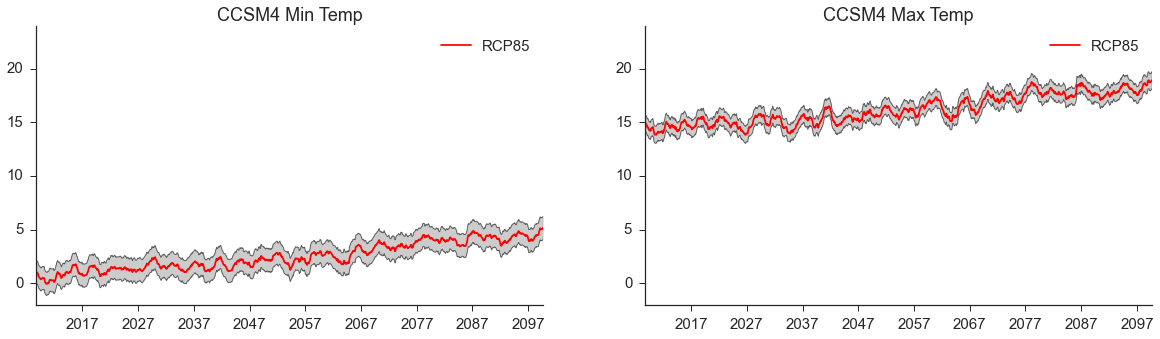

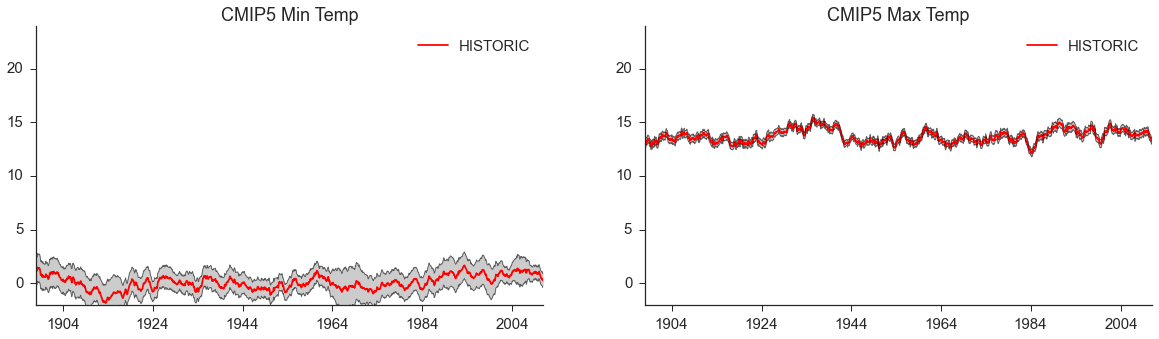

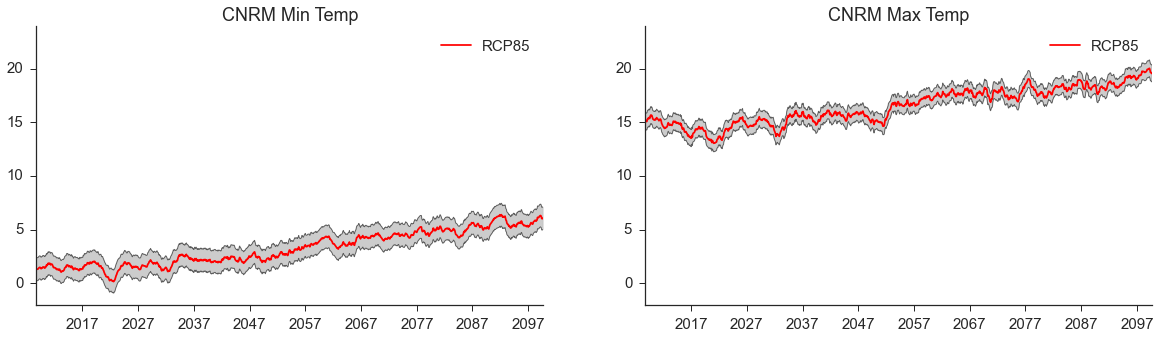

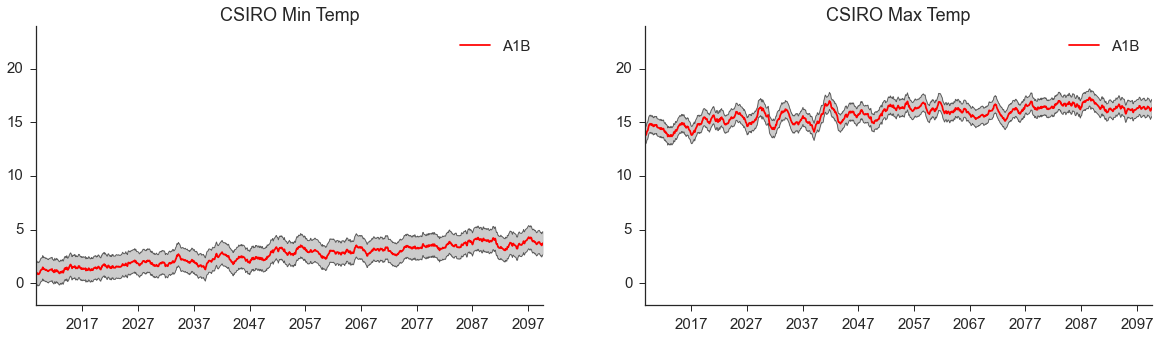

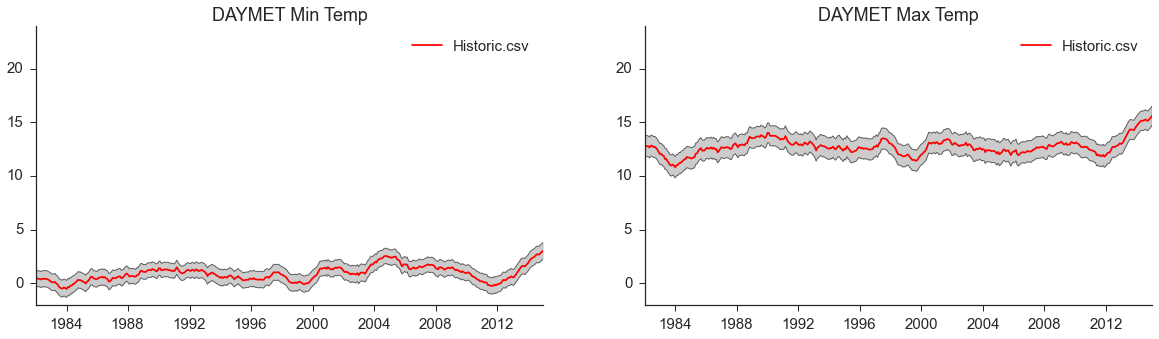

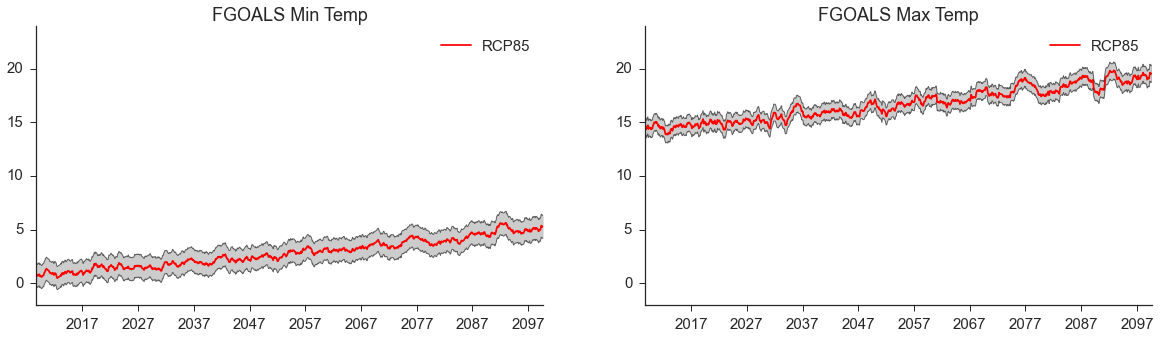

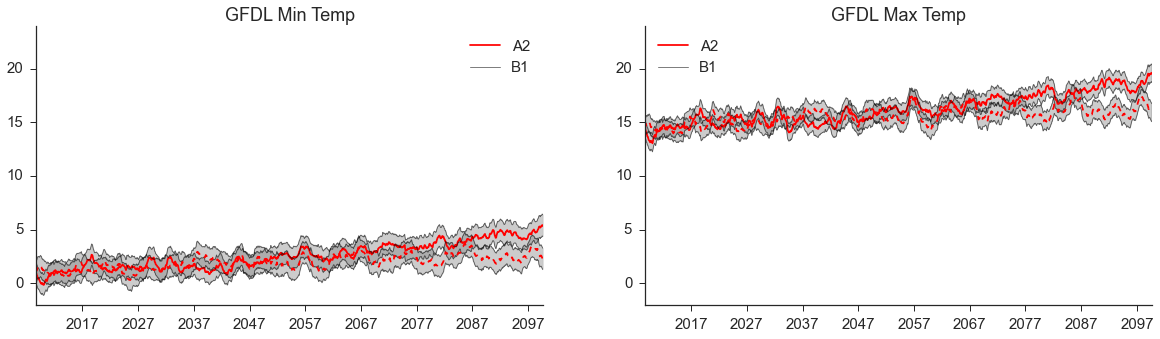

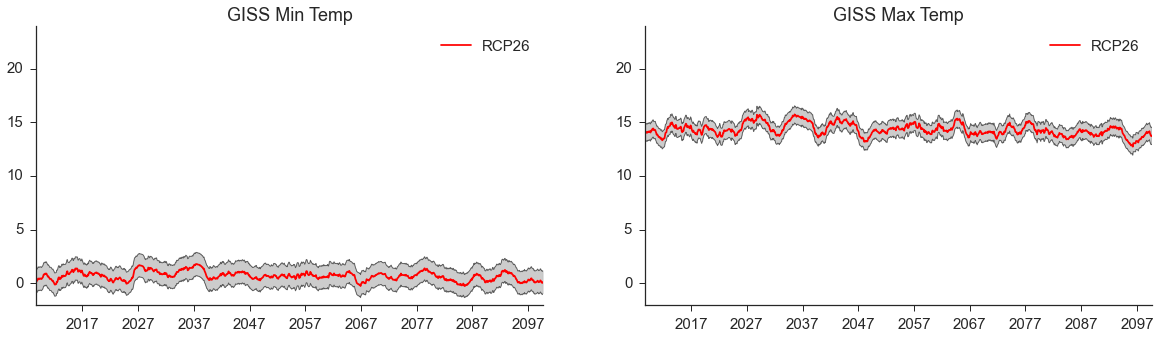

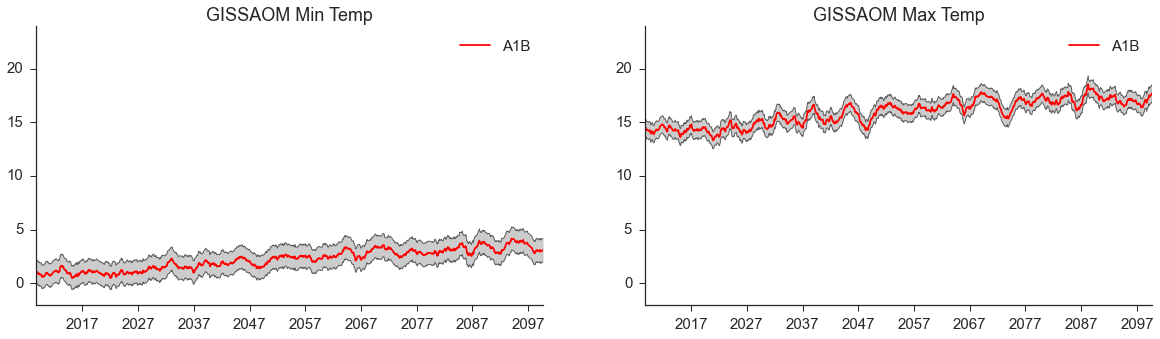

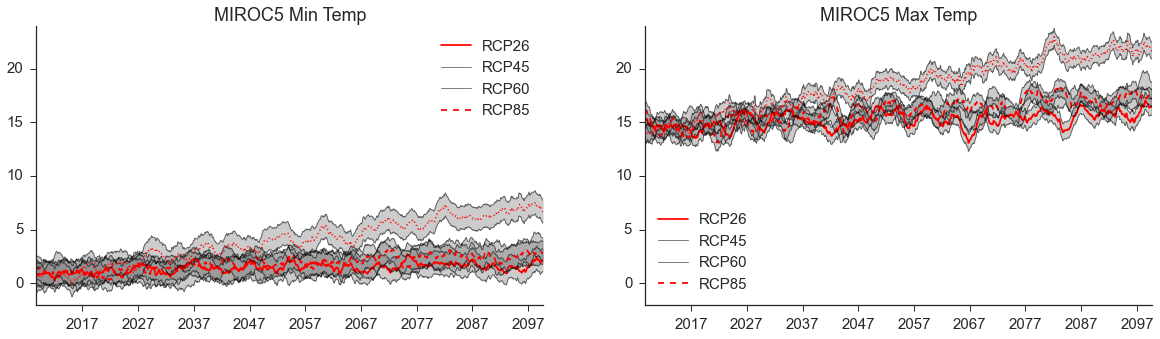

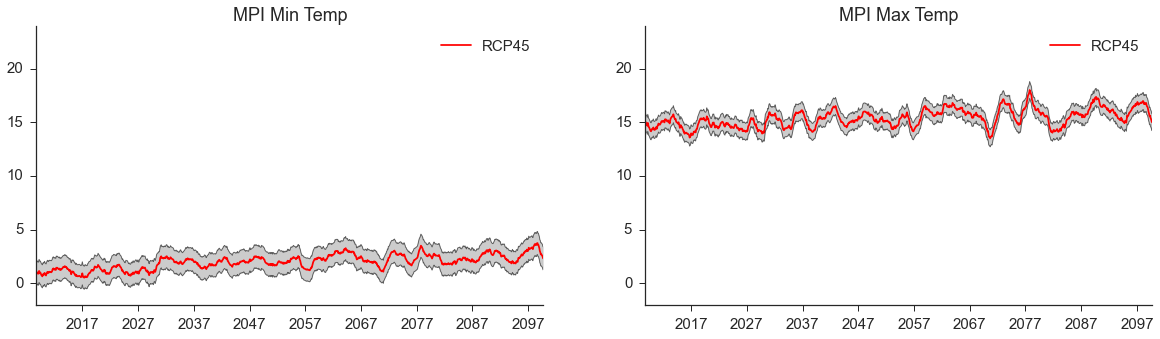

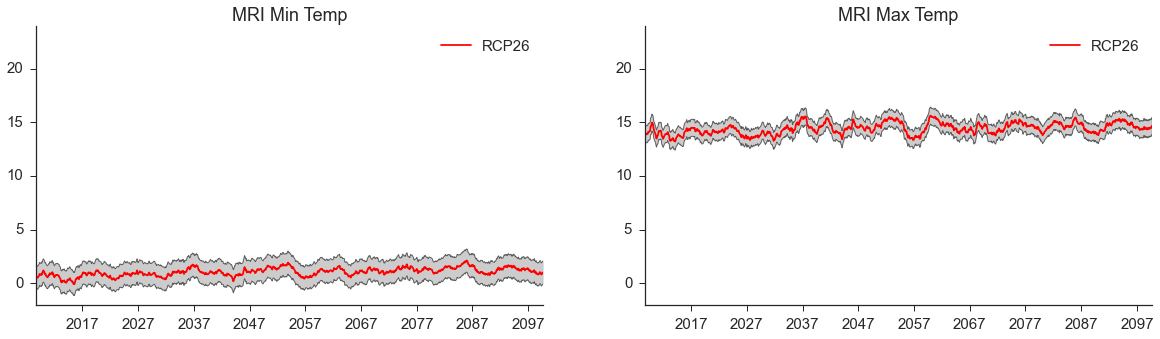

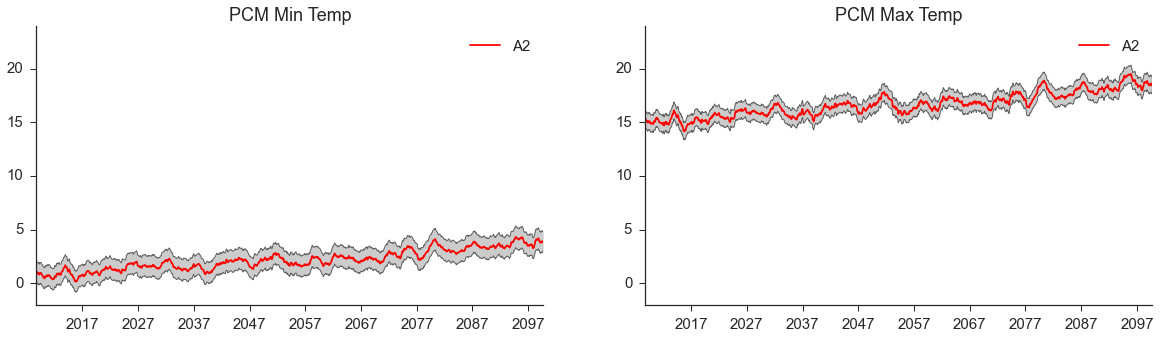

In [16]:
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.5)

DFsub = climateData[climateData.ECOREGION == 'ECO1']
LS = ['-','--','-.-',':']

for model in np.unique(DFsub.MODEL):
    lsidx = 0
    clmdfsub = DFsub[DFsub.MODEL == model]
    f, (ax1, ax2) = plt.subplots(1,2, figsize = (20,5))
    
    for scenario in np.unique(clmdfsub.SCENARIO):
        clmdfsubVAR = clmdfsub[clmdfsub.STAT == 'std']
        clmdfsubS = clmdfsub[clmdfsub.STAT == 'mean']
        
        clmdfsubS.index = clmdfsubS.Time_DTO
        clmdfsubVAR.index = clmdfsubVAR.Time_DTO

        if model == 'DAYMET':
            tsStart = clmdfsubS.index.min()
            tsStop = clmdfsubS.index.max()
            clmdfsubS = clmdfsubS.groupby(['MODEL','SCENARIO','VAR','STAT', 
                                         clmdfsubS.index.year, clmdfsubS.index.month]).mean().reset_index()
            clmdfsubVAR = clmdfsubVAR.groupby(['MODEL','SCENARIO','VAR', 'STAT', 
                                         clmdfsubVAR.index.year, clmdfsubVAR.index.month]).mean().reset_index()
            daymetIndex = pd.date_range(tsStart,tsStop,freq = 'M')

            clmdfsubM = clmdfsubS[clmdfsubS.SCENARIO == scenario]
            tmin = clmdfsubM[clmdfsubM.VAR == 'tmax']
            tmax = clmdfsubM[clmdfsubM.VAR == 'tmin']
            
            # In the DAYMET file, tmax and tmin are swapped
            tminVar = clmdfsubVAR[clmdfsubVAR.VAR == 'tmax']
            tmaxVar = clmdfsubVAR[clmdfsubVAR.VAR == 'tmin']
           
            tmin.index = daymetIndex
            tmax.index = daymetIndex
            tminVar.index = daymetIndex
            tmaxVar.index = daymetIndex

        else:

            clmdfsubM = clmdfsubS[clmdfsubS.SCENARIO == scenario]
            tmin = clmdfsubM[clmdfsubM.VAR == 'tmin']
            tmax = clmdfsubM[clmdfsubM.VAR == 'tmax']
            tminVar = clmdfsubVAR[(clmdfsubVAR.VAR == 'tmin') & 
                                  (clmdfsubVAR.SCENARIO == scenario)]
            tmaxVar = clmdfsubVAR[(clmdfsubVAR.VAR == 'tmax') & 
                                  (clmdfsubVAR.SCENARIO == scenario)]
            
        
        tminSmooth = tmin.VALUE.rolling(window = 24, center=False).mean()
        tminSTD = tminVar.VALUE.rolling(window = 24, center=False).mean()

        y1 = tminSmooth + (tminSTD)
        y2 = tminSmooth - (tminSTD)
        
        ax1.plot(tmin.index, tminSmooth, 
                 color = 'red', ls = LS[lsidx])
        ax1.legend(np.unique(clmdfsub.SCENARIO), loc = 0)

        ax1.set_title(model + ' ' + 'Min Temp')
        ax1.plot(tminSmooth.index, y1,lw = 1, alpha = 0.5,
                 color = 'k')
        ax1.plot(tminSmooth.index, y2,lw = 1, alpha = 0.5,
                 color = 'k')

        ax1.fill_between(tmin.index, y1, y2, 
                         where=y2 <= y1, facecolor='gray', 
                         alpha = 0.4, interpolate=True)
        
        tmaxSmooth = tmax.VALUE.rolling(window = 24, center=False).mean()
        tmaxSTD = tmaxVar.VALUE.rolling(window = 24, center=False).mean()

        y1 = tmaxSmooth + (tmaxSTD)
        y2 = tmaxSmooth - (tmaxSTD)
        
        ax2.plot(tmax.index, tmaxSmooth, 
              color = 'red', ls = LS[lsidx])
        ax2.legend(np.unique(clmdfsub.SCENARIO), loc = 0)

        ax2.set_title(model + ' ' + 'Max Temp')
        ax2.plot(tmaxSmooth.index, y1,lw = 1, alpha = 0.5,
                 color = 'k')
        ax2.plot(tmaxSmooth.index, y2,lw = 1, alpha = 0.5,
                 color = 'k')

        ax2.fill_between(tmax.index, y1, y2, 
                         where=y2 <= y1, facecolor='gray', 
                         alpha = 0.4, interpolate=True)
        lsidx += 1

        
        ax1.set_ylim([-2,24])
        ax2.set_ylim([-2,24])

        sns.despine()

#### Summary plot for the historic spinup and projected data
that go into LANDIS-II (Century weather), placing temperature and precip into context of historic DAYMET data

HISTORIC
Historic.csv
RCP26
RCP85


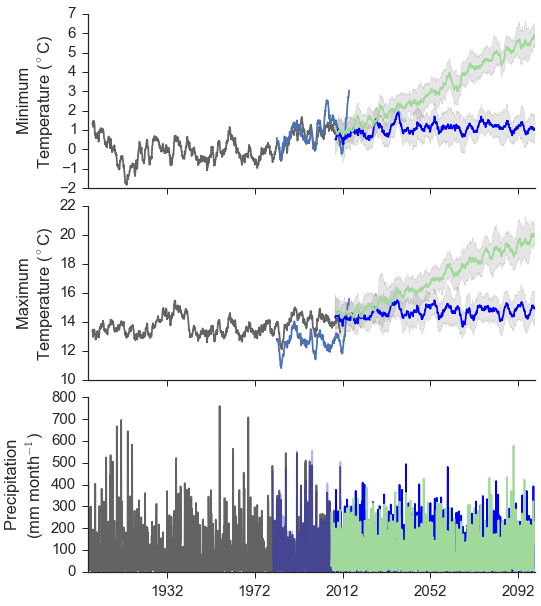

In [17]:
scenarios = ['HISTORIC','Historic.csv','RCP26','RCP85']


sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.5)

DFsub = climateData[climateData.ECOREGION == 'ECO1']
DFsub.index = DFsub.Time_DTO
LS = ['-','--','-.-',':']
f, (ax1, ax2, ax3) = plt.subplots(3,1, figsize = (8,10), sharex = True)
plt.subplots_adjust(hspace = 0.1)
ensembleCMIPM = DFsub.groupby(['SCENARIO','VAR','STAT','Time_DTO',
               DFsub.index.year, 
               DFsub.index.month]).mean().reset_index()

ensembleCMIPSTD = DFsub.groupby(['SCENARIO','VAR','STAT','Time_DTO',
               DFsub.index.year, 
               DFsub.index.month]).std().reset_index()

ensembleCMIPM.index = ensembleCMIPM.Time_DTO
ensembleCMIPSTD.index = ensembleCMIPSTD.Time_DTO

for scenario in scenarios:
    print scenario
    CMIPScenario = ensembleCMIPM[ensembleCMIPM.SCENARIO == scenario]
    CMIPScenarioSTD = ensembleCMIPSTD[ensembleCMIPSTD.SCENARIO == scenario]
    if scenario == 'Historic.csv':
        onesub = CMIPScenario[(CMIPScenario.VAR == 'prcp')&(CMIPScenario.STAT == 'mean')]
        tsStart = onesub.index.min()
        tsStop = onesub.index.max()

        CMIPScenario = CMIPScenario.drop(['level_4','level_5'],1)
        
        # Create a separate grouped dataframe for precip summing purposes
        CMIPScenarioP = CMIPScenario.groupby(['SCENARIO','VAR','STAT',
              CMIPScenario.index.year, 
              CMIPScenario.index.month]).sum().reset_index()

        CMIPScenario = CMIPScenario.groupby(['SCENARIO','VAR','STAT',
                  CMIPScenario.index.year, 
                  CMIPScenario.index.month]).mean().reset_index()
        
        daymetIndex = pd.date_range(tsStart,tsStop,freq = 'M')
        
    tmaxMEAN = CMIPScenario[(CMIPScenario.VAR == 'tmax') & (CMIPScenario.STAT == 'mean')]
    tmaxSTD = CMIPScenarioSTD[(CMIPScenarioSTD.VAR == 'tmax') & (CMIPScenarioSTD.STAT == 'mean')]
    
    tminMEAN = CMIPScenario[(CMIPScenario.VAR == 'tmin') & (CMIPScenario.STAT == 'mean')]
    tminSTD = CMIPScenarioSTD[(CMIPScenarioSTD.VAR == 'tmin') & (CMIPScenarioSTD.STAT == 'mean')]
    
    if scenario == 'Historic.csv':
        prcpMEAN = CMIPScenarioP[(CMIPScenarioP.VAR == 'prcp') & (CMIPScenarioP.STAT == 'mean')]
        prcpSTD = CMIPScenarioSTD[(CMIPScenarioSTD.VAR == 'prcp') & (CMIPScenarioSTD.STAT == 'mean')]
        
    else:
        prcpMEAN = CMIPScenario[(CMIPScenario.VAR == 'prcp') & (CMIPScenario.STAT == 'mean')]
        prcpSTD = CMIPScenarioSTD[(CMIPScenarioSTD.VAR == 'prcp') & (CMIPScenarioSTD.STAT == 'mean')]
        
        
    tmaxSmooth = tmaxMEAN.VALUE.rolling(window = 24, center=False).mean()
    tmaxSTDSmooth = tmaxSTD.VALUE.rolling(window = 24, center=False).std()
    tminSmooth = tminMEAN.VALUE.rolling(window = 24, center=False).mean()
    tminSTDSmooth = tminSTD.VALUE.rolling(window = 24, center=False).std()

    if scenario == 'Historic.csv':
        pltColor = 'blue'
    if scenario == 'HISTORIC':
        pltColor = '#636363'
    if scenario == 'RCP85':
        pltColor = '#a1d99b'

    if scenario != 'Historic.csv':
        y1 = tminSmooth + (tminSTDSmooth)
        y2 = tminSmooth - (tminSTDSmooth)

        ax1.fill_between(tminSmooth.index, y1, y2, 
                         where=y2 <= y1, facecolor='gray', 
                         alpha = 0.2, interpolate=True)


        ax1.plot(tminMEAN.index, tminSmooth, 
              color = pltColor)


        y1 = tmaxSmooth + (tmaxSTDSmooth)
        y2 = tmaxSmooth - (tmaxSTDSmooth)

        ax2.fill_between(tmaxSmooth.index, y1, y2, 
                         where=y2 <= y1, facecolor='gray', 
                         alpha = 0.2, interpolate=True)


        ax2.plot(tmaxMEAN.index, tmaxSmooth, 
              color = pltColor)
        
        
        ax3.plot(prcpMEAN.index, prcpMEAN.VALUE, 
        color = pltColor)

    else:
        tmaxMEAN.index = daymetIndex
        tmaxSmooth.index = daymetIndex
        ax1.plot(tmaxMEAN.index,tmaxSmooth)

        tminMEAN.index = daymetIndex
        tminSmooth.index = daymetIndex
        ax2.plot(tminMEAN.index,tminSmooth)
        
        prcpMEAN.index = daymetIndex
        ax3.plot(prcpMEAN.index, prcpMEAN.VALUE, 
        color = pltColor, alpha = 0.3)

ax1.set_ylabel('Minimum \nTemperature ($^\circ$C)')
ax2.set_ylabel('Maximum \nTemperature ($^\circ$C)')
ax3.set_ylabel('Precipitation \n(mm month$^{-1}$)')

sns.despine()

### Generatring LANDIS-II fire weather from climate projections
Landis-II fire weather requires of us some information that we cannot gleen from the climate projections -- namely windspeed and direction, and relative humidity. 

##### Relative Humidity:
We have to either leverage another model to get at relative humidity, or hope for a strong statistical relationship
between temp and precip and rH. 

##### Windspeed:
Planning on the historic trend of increasing windspeed with increasing fire weather severity in each fire region. This means reading in the RAWS data, binning it by mean air temp and relative humidity, and looking at windspeed across those bins. Also just looking at windspeed distributions as a function of time here might yield some simpler results -- for example, make a distribution of windspeeds in the first 5 years, next 5, next 5... etc, and use that relationship to forcast windspeed.

##### Wind direction:
I have no physical basis for altering wind direction over time. Potentially the directionality of wind would be affected by changes in atmospheric transport and the movement of larger synoptic climate patterns changing with the climate projections. I will just keep the windspeeds the same by creating a mean and std of historic data, and drawing from that distribution.

### Relative Humidity
The approach here is to use statsmodels to fit a linear combination of temp and precip to rH from the fire weather, and cross our fingers for a killer relationship.

In [18]:
# Read in the RAWS weather for the three fire regions
rawsDIR = 'Z:/Dan K/DinkeyCreek/Fire Weather/'
FR1 = pd.read_csv(rawsDIR + 'FR1_RawsWeather.csv')
FR2 = pd.read_csv(rawsDIR + 'FR2_RawsWeather.csv')
FR3 = pd.read_csv(rawsDIR + 'FR3_RawsWeather.csv')
FRS = pd.read_csv(rawsDIR + 'FR1_RawsWeatherS_Final.csv')
# Run the OLS model, including the interaction term
mod = smf.ols(formula='relativehumidity ~ temp * precip_mm -1', data=FR1).fit()
mod.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       relativehumidity   R-squared:                       0.525
Model:                            OLS   Adj. R-squared:                  0.525
Method:                 Least Squares   F-statistic:                     1722.
Date:                Thu, 05 Jan 2017   Prob (F-statistic):               0.00
Time:                        09:03:53   Log-Likelihood:                -23590.
No. Observations:                4674   AIC:                         4.719e+04
Df Residuals:                    4671   BIC:                         4.720e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------
temp               2.0126      0.032     63.563      0.000         1.950     2.075
precip_mm          2.1211      0.073     29.069      0.000         1.978     2.264
temp:precip_mm    -0.1012      0.004    -27.185      0.000        -0.108    -0.094
==============================================================================
Omnibus:                      740.684   Durbin-Watson:                   0.354
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12675.509
Skew:                          -0.145   Prob(JB):                         0.00
Kurtosis:                      11.062   Cond. No.                         74.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

#### Generally its pretty poor ...
But thats sort of going to be a given. One thing we can try is hope for a tighter relationship between time of year and rH ~ temp x precip. Chunking things into month might be useful.

In [19]:
# Create a month index for the fireweather dataframe
for FWData in [FR1, FR2, FR3, FRS]:
    FWIndex = pd.date_range('2001-1-3','2013-12-23', freq = 'D')
    FWIndex =(np.asarray(FWData['year'], 
             dtype='datetime64[Y]')-1970)+ \
             (np.asarray(FWData['Juliandate'], 
             dtype='timedelta64[D]')-1)
    FWData.index = FWIndex
    FWData['MONTH'] = FWData.index.month



#### Check that the grouping worked, look at TEMP as a proxy for success
We can also use this data to sort of gleen where there may be strong nonlinearities in the relationship. Because rH caps out at 100, it makes sense that there might be nonlinear responses at the ends on the relationship -- so when its REALLY cold, or VERY dry most likely.

#### Time since precip?
Along those lines, if we create some measure of time since a precip event, that might allow us to further constrain the relationship. Thats pretty easy to setup and try at least.

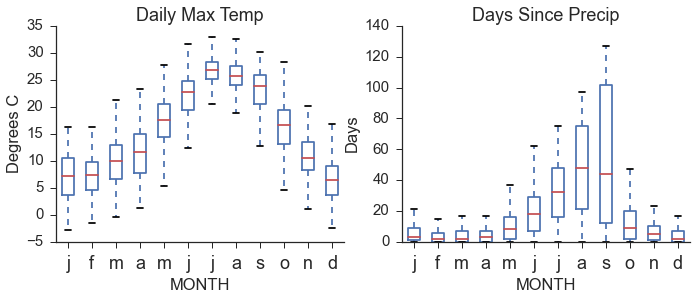

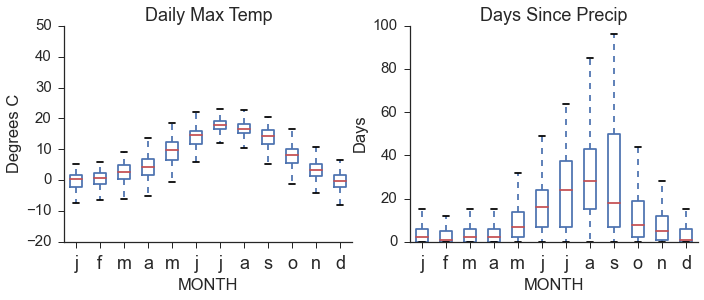

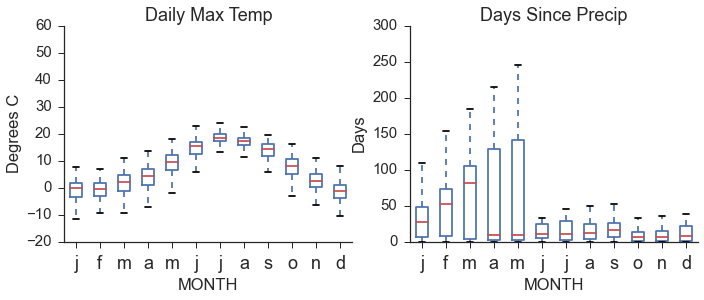

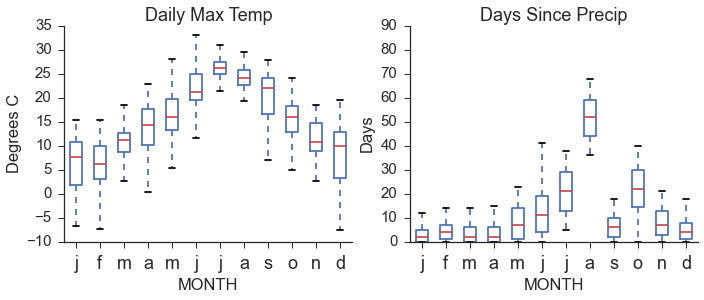

In [20]:
# Check the monthly timestamp by boxplotting TEMP up
for FWData in [FR1, FR2, FR3, FRS]:
    f, (ax1, ax2) = plt.subplots(1,2, figsize = (11,4))
    FWData.boxplot(column='temp', by = 'MONTH', ax = ax1)
    ax1.set_title('Daily Max Temp')
    ax1.set_ylabel('Degrees C')
    sns.despine()
    plt.suptitle('')

    sns.set_style('ticks')

    # Add an array for time since precip
    timeSinceIDX = 1
    timeSinceArray = []
    for day in FWData.precip_mm:
        if day > 0:
            timeSinceIDX = 0
        else:
            timeSinceIDX += 1
        timeSinceArray.append(timeSinceIDX)
    FWData['TimeSinceRain'] = timeSinceArray

    FWData.boxplot(column = 'TimeSinceRain', by = 'MONTH', ax = ax2)
    ax2.set_title('Days Since Precip')
    ax2.set_ylabel('Days')
    plt.suptitle('')

    sns.despine()

    for ax in [ax1, ax2]:
        ax.grid(b=False)
        ax.set_xticklabels(['j','f','m','a','m','j','j','a','s','o','n','d'])

#### Interesting correlation between hottest months and time since precip
Should lend some credence to the interactions between precip, time since precip, and temp in the model. As for how to go about fitting models -- by month makes sense, given we can try and eliminate or constrain the variability described above. Further, we can contrive a ton of model structures ... not to get too complicated, if we specify the permutations that include relavent interactions for ordinal, log, and log log transformations, we should cover our bases. I figure the log log transformations will work out best knowing what I do about the relationship between temp and water holding capacity of the air.

In the end its just a crude stats tool to fill in some data --- but ideally we have high fit statistics and high significance. 

In the fitting scheme, I'll use adjusted R2 as a fit metric, which should weight added complexity of the model form against the degrees of freedom lost by adding predictors. Basically, we'll loop through the models, store the fit metric, and pick the model corresponding to the best fit. I can add in AIC or BIC here if people  get ornery, but I doubt it will make much of a difference in this application of the hierarchy approach.

In [21]:
# Quick smattering of model forms / structures
models = ['relativehumidity ~ temp',
         'relativehumidity ~ precip_mm',
         'relativehumidity ~ temp + precip_mm ',
         'relativehumidity ~ temp * precip_mm ',
         'relativehumidity ~ temp + precip_mm + TimeSinceRain ',
         'relativehumidity ~ temp * precip_mm + TimeSinceRain ',
         'relativehumidity ~ temp -1',
         'relativehumidity ~ precip_mm -1',
         'relativehumidity ~ temp + precip_mm  -1',
         'relativehumidity ~ temp * precip_mm  -1',
         'relativehumidity ~ temp + precip_mm + TimeSinceRain  -1',
         'relativehumidity ~ temp * precip_mm + TimeSinceRain  -1',
         # Log Transformation (dependent only)
         'np.log(relativehumidity) ~ temp',
         'np.log(relativehumidity) ~ precip_mm',
         'np.log(relativehumidity) ~ temp + precip_mm ',
         'np.log(relativehumidity) ~ temp * precip_mm ',
         'np.log(relativehumidity) ~ temp + precip_mm + TimeSinceRain ',
         'np.log(relativehumidity) ~ temp * precip_mm + TimeSinceRain ',
         'np.log(relativehumidity) ~ temp -1',
         'np.log(relativehumidity) ~ precip_mm -1',
         'np.log(relativehumidity) ~ temp + precip_mm  -1',
         'np.log(relativehumidity) ~ temp * precip_mm  -1',
         'np.log(relativehumidity) ~ temp + precip_mm + TimeSinceRain  -1',
         'np.log(relativehumidity) ~ temp * precip_mm + TimeSinceRain  -1',
         # Log x Log Transormation
         'np.log(relativehumidity) ~ np.log(temp)',
         'np.log(relativehumidity) ~ precip_mm',
         'np.log(relativehumidity) ~ np.log(temp) + precip_mm ',
         'np.log(relativehumidity) ~ np.log(temp) * precip_mm ',
         'np.log(relativehumidity) ~ np.log(temp) + precip_mm + TimeSinceRain ',
         'np.log(relativehumidity) ~ np.log(temp) * precip_mm + TimeSinceRain ',
         'np.log(relativehumidity) ~ np.log(temp) -1',
         'np.log(relativehumidity) ~ precip_mm -1',
         'np.log(relativehumidity) ~ np.log(temp) + precip_mm  -1',
         'np.log(relativehumidity) ~ np.log(temp) * precip_mm  -1',
         'np.log(relativehumidity) ~ np.log(temp) + precip_mm + TimeSinceRain  -1',
         'np.log(relativehumidity) ~ np.log(temp) * precip_mm + TimeSinceRain  -1']

# Function to pick the best model for fitting rH given temp and precip
# data. During some times of year this won't work that well, and so error
# handling should record the failure as a 'DNC' for did not converge.
def pickBestModel(inputDF, modelList, month, addPlots):
    idx = 0
    if idx == 0:
        rsquareds = []
        count = []
        
    # Loop through the potential model forms
    for model in modelList:
        
        # Attempt the ols fit -- this may fail given the nonlinearities
        # or data gaps present in the data set.
        try:
            est = smf.ols(formula=model, 
                          data=inputDF).fit(conv = 'weights')
            
        # If it does fail to converge, record the rsquared as -9999
        except: 
            rsquareds.append(-9999)
            
        # otherwise record the actual rsquared.
        else:
            rsquareds.append(est.rsquared_adj)
        count.append(idx)
        
        sns.set_style('ticks')
        idx += 1
    monthModelInfo = pd.DataFrame(dict(modelNum = count, 
                                       RSquared_adj = rsquareds, month = month))
    winner = monthModelInfo.modelNum[monthModelInfo.RSquared_adj == monthModelInfo.RSquared_adj.max()]
    est = smf.ols(formula=models[winner.values[0]],data=FRMonth).fit(conv = 'weights')
    FRMonth.relativehumidity[np.isnan(np.log(FRMonth.temp))] = np.nan
    if addPlots == 'y':
        f, (ax1, ax2) = plt.subplots(1,2, figsize = (14,7))
        ax1.set_title(str(year) + ' ' + str(month))
        ax1.plot(np.log(FRMonth.relativehumidity.dropna()),est.fittedvalues, 'o')
        ax2.plot(FRMonth.dropna().index.dayofyear, FRMonth.relativehumidity.dropna(), 'or')
        ax2.plot(FRMonth.dropna().index.dayofyear, np.exp(est.fittedvalues), 'o', color = 'gray')
        ax2.set_ylim([0,100])
        sns.despine()
    return monthModelInfo

#### Now we run the function on all years worth of data by month
and hope to produce good fits in at least some of the model structures. Because our fit selector is designed to run on any dataframe we give it, our loop to call the function has to be based on subsets of the RAWS data, by month. Working with small sets of data actually really increase our potential performance. Our plan here is to populate seasonal distributions with the rH data predicted by theses relationships -- ultimately for the projected climate, this will be chinked up into 10 year bins -- so running the model on annual time steps will give us the most variability through time and within season.

In [23]:
idx = 0
#year = 2004
for month in np.unique(FR1.index.month):
    FRMonth = FR1[FR1.index.month == month]
    FRMonth[FRMonth.temp < 0] = np.nan
    if idx == 0:
        allMods = pickBestModel(FRMonth, models, month, 'n')
    else:
        monthMod = pickBestModel(FRMonth, models, month, 'n')
        allMods = pd.concat([allMods, monthMod])
    idx += 1

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\pandas\core\generic.py:4428: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:9: SettingWithCopyWarning: 
A va

In [24]:
idx = 0
nameIDX = 0
FRNames = ['FR1','FR2','FR3','FRS']
for FRData in [FR1,FR2,FR3,FRS]:
    FRName = FRNames[nameIDX]
    for year in np.unique(FRData.index.year):
        FRData_y = FRData[FRData.index.year == year]

        for month in np.unique(FRData_y.index.month):
            FRData_ym = FRData_y[FRData_y.index.month == month]
            
            # Remove negative temperatures -- we don't do that well
            FRData_ym[FRData_ym.temp < 0] = np.nan
            if idx == 0:
                allMods = pickBestModel(FRData_ym, models, month, 'n')
                allMods['year'] = year
                allMods['FR'] = FRName

            else:
                monthMod = pickBestModel(FRData_ym, models, month, 'n')
                monthMod['year'] = year
                monthMod['FR'] = FRName

                allMods = pd.concat([allMods, monthMod])
            idx += 1
    nameIDX += 1

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Now we have a dataframe that contains the results of our curve fitting
This still doesn't get us to the point where we have generated data ... but it  give's us the tools to get there. An important step along the way is to create some summary figures of the process -- one should show a graphical representation of our model fit statistics, and one should show the 1:1 plots by month for a given year to illustrate the RMSE we're building into the data. 

#### Even though we're going to just take the best model form
and use it to generate the rH data by season, we can make use of all of the model fits to look at how fits change by month across models. 

Lets take all the data and quickly visualize the fit capability using this approach as a funciton of Month. Here we can see there is a strong seasonal cycle to the fit capability, and some models (the nonlinear ones) are less influenced by the change in temperature. Keep in mind here we are only doing curve fitting for days with temperature > 0.

In [ ]:
for FRName in np.unique(allMods.FR):
    allMods['monthYear'] = (allMods.year + (allMods.month)/100)
    FRdata = allMods[allMods.FR == FRName]
    allYears = np.unique(FRdata.year)
    del FRdata['year']
    del FRdata['month']
    del FRdata['FR']

    resultsWide = FRdata.pivot_table(values = 'RSquared_adj', 
                                     index = 'modelNum', 
                                     columns = 'monthYear')

    bestFit = []
    monthList = []
    for month in resultsWide.columns:
        bestFit.append(resultsWide[month].argmax())
        monthList.append(month)

    cols = resultsWide.columns.size
    rows = len(resultsWide)

    resultsWide[resultsWide < 0] = 0
    f, ax1 = plt.subplots(1,1, figsize = (12,7))
    ax = ax1.imshow(resultsWide, interpolation='nearest', aspect = 2.3, cmap='bone').axes
    _ = ax.set_xticks(np.linspace(0, cols, 14))
    _ = ax.set_xticklabels(allYears)
    _ = ax.set_yticks([2.5,8.5,14.5,20.5,26.5, 32.5])
    _ = ax.set_yticklabels(['rH ~ Data\n + Intercept', 
                            'rH ~ Data\n No Intercept',
                            'log(rH) ~ Data\n + Intercept',
                           'log(rH) ~ Data\n No Intercept',
                           'log(rH) ~ log(Data)\n+ Intercept',
                           'log(rH) ~ log(Data)\n No Intercept'])
    ax.set_xlabel(FRName)
    ax.grid('off')
    ax.xaxis.tick_top()
    plt.tight_layout()
    plt.savefig(FRName + '_AllYears_rHFits.tif', dpi = 150)


#### Now we have a tool to generate rH data from projected climate data
Let's iterate through the CMIP5 data and start building dataframes of fire weather inputs. The goal here is to basically create a synthetic RAWS data file that we can associate with each climate projection file, and ultimately run through our existing fire weather generation scripts. 

To start, I'll test the process on the existing RAWS data, which has rH data that was measured. That way we can generate our 1:1 curve figure to illustrate the curve fit approach.

#### Iterating over new data is tricky
We have to predict the rH values from data sets we've never driven our model with before. This can get a bit fussy using statsmodels, as the dataframe you generate the model fit with is appended with some statsmodels specific information called the design matrix. When we move around or change the DFs that were used to generate the model fit, the design matrix is not carried with it. That being said, we can recreate the design matrix information to charge on through -- we just have to do some string splitting to get the format correct.

Namely, if a patsy function of the form 'y ~ x + b * c' is the model form you fit the data to, we only want to preserve 'x + b * c', so a string split at '~ ', including the trailing space, should return the model form we dynamically select for fire region, year, and month.

In [ ]:
cmip = ensembleCMIPM[ensembleCMIPM.SCENARIO == scenario]
cmipRAWS = pd.DataFrame(dict(temp = cmip[(cmip.VAR == 'tmin') & (cmip.STAT == 'mean')].VALUE,
                             precip_mm = cmip[(cmip.VAR == 'prcp') & (cmip.STAT == 'mean')].VALUE))
cmipRAWS['MONTH'] = cmipRAWS.index.month
cmipRAWS['year'] = cmipRAWS.index.year
timeSinceIDX = 1
timeSinceArray = []
for rain in cmipRAWS.precip_mm:
    if rain > 0:
        timeSinceIDX = 0
    else:
        timeSinceIDX += 1
    timeSinceArray.append(timeSinceIDX)
cmipRAWS['TimeSinceRain'] = timeSinceArray


### In a hideous twist of fate
Since I built the relationships on daily RAWS data, and the 270 meter downscaled data we can get is Monthly, the entire regression plan is pretty bunk. We have a new plan -- use daily projected climate data at a courser resolution. It comes with extra perks:

#### 1/24 degree downscaled MACA climate ensembles:
By using this product: https://cida.usgs.gov/thredds/dodsC/macav2metdata_daily_future, we do lose some spatial variability. However, we don't need as much described given the size and homgeneity of our fire regions. Further, we can actually use projected rH for a subset of climate models. Heres the rub: in order to only use fire weather models that contain rH, and have corresponding monthly downscaled data, we are limited to three climate models: MIROC5, CCSM4, CNRM. That drops FGOALS from the list. 

The decision we made was to use the existing 3 climate projections (8.5 forcings) that have the parameters we need calculated, and create a single fire weather from them. The first step will be to create decadal subsets of each projection, then to calculate the apropriate fire weather indices from each decadal subset, and finally to combine the three projections for each decade to make the final 10 FW distributions.

### Wind Speed
The decided approach is to create distibutions of wind speed using each fire regions data, split up into 10 increasing wind speed bins. Each fire region's data will have the extreme rim fire windspeeds appended to them, ultimately producing rim fire speeds for the end of simulation decades.

First, lets create the cumulative distribution function for windspeed in our simulation, starting with FR1 as an example.

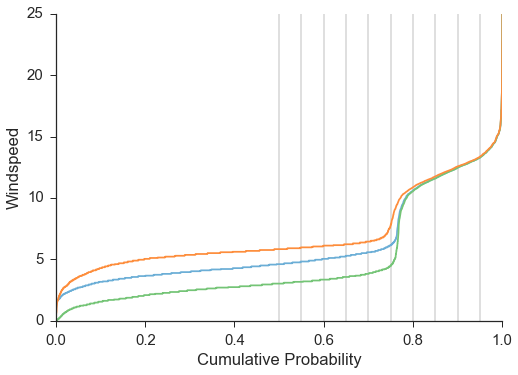

In [60]:
# First lets read in the old fire weather and plot distributions of the wind speeds.
FR1 = pd.read_csv(DFFSDir + 'FR1_RawsWeather.csv')
FR2 = pd.read_csv(DFFSDir + 'FR2_RawsWeather.csv')
FR3 = pd.read_csv(DFFSDir + 'FR3_RawsWeather.csv')
FRS = pd.read_csv(DFFSDir + 'FR1_RawsWeatherS_Final.csv')

FRcolors = ['#6baed6','#74c476','#fd8d3c']
f, ax = plt.subplots()
idx = 0
for FR in [FR1, FR2, FR3]:
    
    # Add in some years of severe wind data
    FR_winds = FR.windspeed.append(FRS[FRS.year >= 2010].windspeed)

    # Calculate the CDF of our distribution
    sortedWind = np.sort(FR_winds)
    p = 1. * np.arange(len(sortedWind)) / (len(sortedWind) - 1)

    sns.set_context('notebook', font_scale=1.5)
    # plot an exmaple CDF
    ax.plot(p, sortedWind, color = FRcolors[idx])
    ax.set_xlabel('Cumulative Probability')
    ax.set_ylabel('Windspeed')
    sns.despine()
    sns.set_style('ticks')
    pecentiles = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
    idx += 1
ax.vlines(pecentiles, 0, 25, alpha = 0.7, color = '#cccccc')


### Now that we have a data driven probability distribution function
we can draw from it in a way that increases the severity of wind speed by decade. I createad the distributions such that in early decades there is a low probability of drawing from severe wind, and in late decades there is a small probability of drawing from contemporary wind speeds. This seems a little bit like creating the perfect storm to increase fire weather severity over the course of the simulation, but really this is a tempered representation compared to the previously published high severity simulations we ran using the Rim fire data.

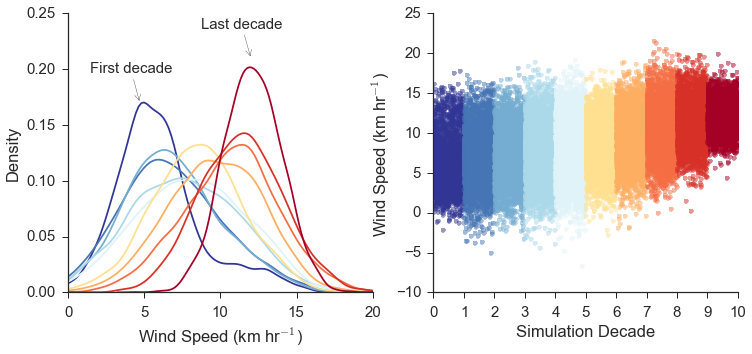

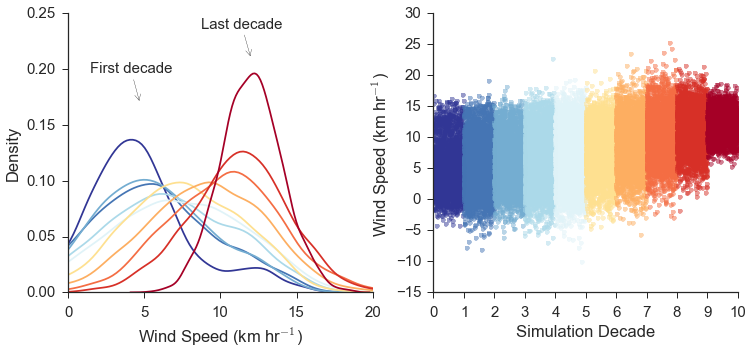

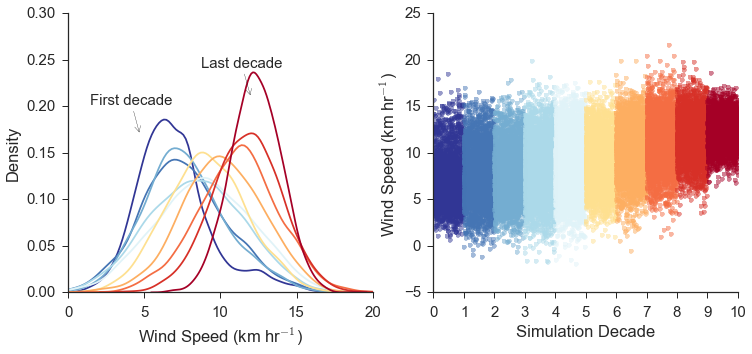

In [62]:
pecentiles = [0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]
percentileMap = ['#a50026','#d73027','#f46d43','#fdae61','#fee090','#e0f3f8','#abd9e9','#74add1','#4575b4','#313695']

for FR in [FR1, FR2, FR3]:
    
    # Add in some years of severe wind data
    FR_winds = FR.windspeed.append(FRS[FRS.year >= 2010].windspeed)

    # Calculate the CDF of our distribution
    sortedWind = np.sort(FR_winds)
    p = 1. * np.arange(len(sortedWind)) / (len(sortedWind) - 1)

    idx = 0
    fig1 = plt.figure(figsize= (12,5))
    ax1 = fig1.add_subplot(121)
    for percent in pecentiles:

        if percent < 0.6:
            decadalMean = sortedWind[np.isclose(p, percent, rtol = 0.7)].mean()
            decadalStd = sortedWind[np.isclose(p, percent, rtol = 0.7)].std()      
        elif (percent <= 0.65) & (percent > 0.5):
            decadalMean = sortedWind[np.isclose(p, percent, rtol = 0.5)].mean()
            decadalStd = sortedWind[np.isclose(p, percent, rtol = 0.5)].std()
        elif percent == 0.7:
            decadalMean = sortedWind[np.isclose(p, percent, rtol = 0.4)].mean()
            decadalStd = sortedWind[np.isclose(p, percent, rtol = 0.4)].std()

        else: 
            decadalMean = sortedWind[np.isclose(p, percent, rtol = 0.2)].mean()
            decadalStd = sortedWind[np.isclose(p, percent, rtol = 0.2)].std()
        decadalWind = pd.DataFrame(dict(winds = np.random.normal(loc=decadalMean, scale=decadalStd, size=365 * 9)))

        count, bins, ignored = plt.hist(decadalWind.winds, 30, normed=True, alpha = 0.00)
        chanceHighWind = pd.DataFrame(dict(winds = FRS[FRS.year == random.choice(FRS.year)].windspeed))
        extremeWinds = pd.DataFrame(dict(winds = np.random.normal(loc=chanceHighWind.winds.mean(), 
                                    scale=chanceHighWind.winds.std(), size=365)))  
        decadalWind = decadalWind.append(extremeWinds)
        decadalWind = decadalWind.sample(frac=1).reset_index(drop=True)
        if idx == 0:
            allWinds = pd.DataFrame(dict(wind = decadalWind.winds, decade = idx))
        else:
            windDF = pd.DataFrame(dict(wind = decadalWind.winds, decade = idx))
            allWinds = pd.concat([allWinds, windDF])

        sns.distplot(decadalWind, color = np.flipud(percentileMap)[idx], hist=False, ax = ax1, norm_hist=True)
        idx += 1
    sns.despine()
    ax1.set_xlabel('Wind Speed (km hr$^{-1}$)')
    ax1.set_ylabel('Density')
    ax1.set_xlim([0,20])

    allWinds = allWinds.reset_index()
    ax2 = fig1.add_subplot(122)
    for decade in np.unique(allWinds.decade):
        thisDecade = allWinds[allWinds.decade == decade]
        thisDecade.wind.plot(ax = ax2, linestyle = '', marker = '.', alpha = 0.5, markersize = 10,
                            color = np.flipud(percentileMap)[decade])
        sns.set_style('ticks')

    ax1.annotate('First decade', xy=(4.7, 0.17), xycoords='data',
                xytext=(-50, 30), textcoords='offset points', size = 15,
                arrowprops=dict(arrowstyle="->")
                )
    ax1.annotate('Last decade', xy=(12, 0.21), xycoords='data',
                xytext=(-50, 30), textcoords='offset points', size = 15,
                arrowprops=dict(arrowstyle="->")
                )
    

    ax2.set_ylabel('Wind Speed (km hr$^{-1}$)')
    ax2.set_xlabel('Simulation Decade')
    ax2.set_xticks(np.linspace(0, allWinds.wind.size, 11))
    ax2.set_xticklabels(['0','1','2','3','4','5','6','7','8','9','10'])
    sns.despine()


#### Just have to clean this up a bit
and remove the negative values, and make sure we are matching up the number of entries in our distribution with the number of entries in our climate ensembles. I'm enclined to bring in and format the climate projections now, and handle matching up these time stamps after they are all broken up into decades.

#### Read in the climate projection data
We need to import the climate projections for the three climate models we are using to get fire weather data, all from the CMIP 5 runs. Only two models overlap with our climate projections: CNRM-CM5 and MIROC5. From both of these projections, we need Precip, TMIN, TMAX, RHMIN and RHMAX. We will calculate an average for the temp and rH values, an generally try to emulate a RAWS data format for input into the fire weather generation scripts we've modified from Louise Loudermilk.

In [37]:
# Directory of the FW subsets
FWProjDir = 'Z:/Dan K/DinkeyCreek/Climate Projections/ProjectedFW/ProjectionVariables/'

# iterate over the files we want to read in for the projected FW creation
FWProjections = next(os.walk(FWProjDir))[2]

# Iterate over the model names and associated forcings (scenarios)
# Append the model and variable to each dataframe, split them by fire region
# Concatenate each fire regions worth of data and export it to a csv.
idx = 0
for filename in FWProjections:
    FWData = pd.read_csv(FWProjDir + filename)
    FWData['MODEL'] = filename.split('_')[1].split('.')[0]
    FWData['VAR'] = filename.split('_')[0]
    for F_region in [1, 2, 3]:
        FRvar =  FWData.loc[:,[FWData.columns[0],FWData.columns[F_region], 
                  FWData.columns[F_region + 3], FWData.columns[F_region + 6], 
                  FWData.columns[10], FWData.columns[11]]]
        FRvar.columns = ['Timestep','Mean','Variance','STD','Model','Variable']
        FRvar['FR'] = 'FR' + str(F_region)
        if F_region == 1:
            allFW_Data = FRvar
        else:
            allFW_Data = pd.concat([allFW_Data, FRvar])
        # Write the output of all fire regions by model and variable to a csv file
        allFW_Data.to_csv(FWProjDir + 'processingOut/' + 'FW_Vars_' + \
                          filename.split('_')[1].split('.')[0] + '_' + \
                          filename.split('_')[0] + '.csv')
    # Combine all models and variables into a single dataframe
    if idx == 0:
        allModsVars = allFW_Data
    else:
        allModsVars = pd.concat([allModsVars, allFW_Data])
    idx += 1



### Now we need to begin to format the data into what looks like RAWS data
This entails creating a mean Ta, Rh, and adding a julian day and year column -- we also want these data to be wide formatted, not long.

In [77]:
CNRMCM5_FW = allModsVars[allModsVars.Model == 'CNRM-CM5']
MIROC5_FW = allModsVars[allModsVars.Model == 'MIROC5']

for model in [CNRMCM5_FW, MIROC5_FW]:
    TAMAX = model[model.Variable == 'TAMAX'].reset_index()
    TAMIN = model[model.Variable == 'TAMIN'].reset_index()
    RHMAX = model[model.Variable == 'RHMAX'].reset_index()
    RHMIN = model[model.Variable == 'RHMIN'].reset_index()
    PRECIP = model[model.Variable == 'PRECIP'].reset_index()

    TAavg = (TAMAX.Mean + TAMIN.Mean) / 2
    RHavg = (RHMAX.Mean + RHMIN.Mean) / 2
    FW_Inputs = pd.DataFrame(dict(Timestep = PRECIP.Timestep, Precip = PRECIP.Mean,
                                      rH = RHavg, Ta = TAavg, FR = PRECIP.FR))

    FW_Inputs.index = pd.to_datetime(FW_Inputs.Timestep)
    FW_Inputs['jday'] = FW_Inputs.index.dayofyear
    FW_Inputs['Year'] = FW_Inputs.index.year
    del FW_Inputs['Timestep']
    FW_Inputs.reset_index()
    FW_Inputs.to_csv(FWProjDir + 'processingOut/' + PRECIP.Model[0] + '_AllFW.csv')

### And we have to break up the data by decade
Because the fire weather prep scripts do not distinguish years, they create distributions based on season.

In [113]:
thisDecade['Decade'].iloc[0]

2

In [114]:
models = ['MIROC5', 'CNRM-CM5']
for model in models:
    allYears = pd.read_csv('Z:/Dan K/DinkeyCreek/Climate Projections/ProjectedFW/' + model + '_AllFW' + '.csv')
    Decades = np.arange(0,10,1)
    for decade in Decades:
        thisDecade = allYears[(allYears.Year >= 2000. + (10 * decade)) & (allYears.Year < 2000. + (10*(decade + 1)))]
        thisDecade['Decade'] = decade+1
        thisDecade.to_csv('Z:/Dan K/DinkeyCreek/Climate Projections/ProjectedFW/' + \
                          model + '_decade_' + str(thisDecade['Decade'].iloc[0]) + '.csv')

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
